# CS475 Natural Language Model - Programming Assignment 1

## Submission Guide

This homework is built on top of Micrograd by Andrej Karpathy. He has an excellent [tutorial](https://youtu.be/VMj-3S1tku0?si=EpsUsPGzZs5mIBMi) going over the codebase and building it from scratch. You should have no difficulty solving this homework if you understand that tutorial.

**How to submit**
* Fill out <mark>TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
* Submit one file: hw1_{student_ID}.ipynb to KLMS
    e.g.hw1_20243150.ipynb
* **Late submission policy**: After the submission deadline, you will
immediately lose 20% of the score, another 20% after 24 hours later, and so on.
Submission after 72 hours (3 days) will not be counted. However, you can use late days for this assignment, for which you have to send an email to inform the TAs. See course syllabus website Late Policy section.

**Note**
* Make a copy of this .ipynb file. Do not directly edit this file.
* You are required to use numpy, do not use neither pytorch nor tensorflow.
* Check whether your whole cells work well by restarting runtime code and running all before the submission.
* TA will look into the implemented functions, their validity and give corresponding score to each <mark>TODO</mark> problem.
* Ask questions through Slack so that you can share information with other students.
* TA in charge: Yeahoon Kim (yeahoon.kim@kaist.ac.kr)


**In this programming assignment, you will**
* Learn how the backporpagation works.
* Learn how the pytorch module works.

In [126]:
# Import cell
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from graphviz import Digraph
%matplotlib inline

# set seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

## 1. Derivation of a simple function with one input

### 1.1. What is derivation?

Derivation is a mathematical process used to find the rate of change of a function with respect to its input variables. It is an essential tool in calculus and is widely used in various fields of science and engineering.

In programming, we can approximate the derivative of a function by using numerical methods. One common method is called the **"finite difference approximation."**

The finite difference approximation calculates the derivative by estimating the slope of the function at a given point. It does this by taking the difference between the function values at two nearby points and dividing it by the difference in their corresponding input values. This can be expressed as an equation as follows:

$\frac{f(x+h)-f(x)}{h}$

You can check the detail in [here](https://en.wikipedia.org/wiki/Finite_difference)

### 1.2. Simple example of the derivation
The following is the basic example of the derivation

In [127]:
################## TODO: Implement the gradient function ##################
# The gradient function should take a function f and a point x and return the gradient of f at x.
# The gradient should be approximated using finite differences with a small step size h.
# The function f is assumed to be scalar-valued.
def gradient(f, x: float, h=1e-5) -> float:
    return (f(x + h) - f(x)) / h
###########################################################################

In [128]:
# Define function f(x)
def f(x: float) -> float:
    return 3 * x**2 - 4 * x + 5

# Find the gradient of f(x) at x = 2
x = 2
df = gradient(f, x)

print(f"Gradient of function f at the point {x}: {df:.3f}")

Gradient of function f at the point 2: 8.000


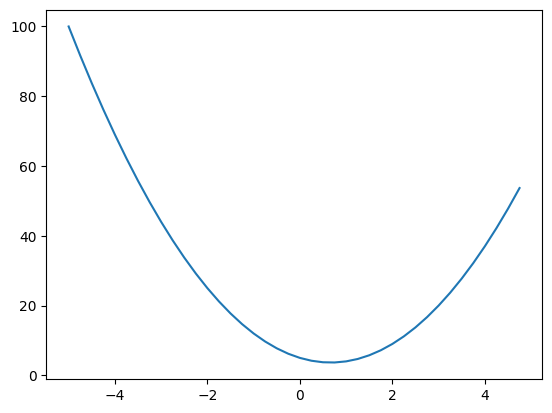

In [129]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## 2. Implement backpropagation

### 2.1. Implement value object for the gradient flow
The `Value` object is a class that represents a scalar value and its gradient. It is used in the context of gradient descent and backpropagation algorithms. The `Value` object has the following attributes and methods:

**Attributes:**
- `data`: The scalar value stored in the object.
- `grad`: The gradient of the scalar value with respect to some variable.
- `_backward`: A function that defines the backward pass of the backpropagation algorithm.
- `_prev`: A set of `Value` objects that are the inputs to the operation that produced this object.
- `_op`: A string that represents the operation that produced this object.

**Methods:**
- `__add__(self, other)`: Overloads the `+` operator to perform addition between two `Value` objects or a `Value` object and a scalar.
- `__mul__(self, other)`: Overloads the `*` operator to perform multiplication between two `Value` objects or a `Value` object and a scalar.
- `__pow__(self, other)`: Overloads the `**` operator to perform exponentiation between a `Value` object and an integer or float.
- `relu(self)`: Applies the rectified linear unit (ReLU) activation function to the `Value` object.
- `backward(self)`: Performs the backward pass of the backpropagation algorithm to compute the gradients of the `Value` object and its inputs.

The `Value` object is used in the implementation of neural networks and other machine learning algorithms to compute gradients and update the model parameters during training. It allows for automatic differentiation and efficient computation of gradients using the chain rule.

<mark>TODO</mark> Implement the activation functions.

In [130]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def log(self):
        out = Value(math.log(self.data), (self,), 'log')

        def _backward():
            self.grad += (1/self.data) * out.grad
        out._backward = _backward

        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    ############# TODO: implement more activation functions ############
    # You can implement more activations such as sigmoid, tanh, silu, gelu, elu etc.
    # Make sure to implement their gradients as well.
    # If there is an activation function you want to implement, implement it here.
    
    def sigmoid(self):
        # You can refer to the following link to implement the sigmoid function
        # https://en.wikipedia.org/wiki/Sigmoid_function
        out = Value(1 / (1 + math.exp(-self.data)), (self,), 'Sigmoid')

        def _backward():
            exp_of_data = math.exp(-self.data)
            self.grad += exp_of_data / ((1 + exp_of_data) ** 2) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        # You can refer to the following link to implement the tanh function
        # https://en.wikipedia.org/wiki/Hyperbolic_function
        out = Value(math.tanh(self.data), (self,), "Tangent Hyperbolic")

        def _backward():
            return (1 - math.tanh(self.data) ** 2) * out.grad
        out._backward = _backward

        return out

    
    def silu(self):
        # You can refer to the following link to implement the SiLU function
        # https://arxiv.org/abs/1702.03118
        out = Value(self.data / (1 + math.exp(-self.data)), (self,), 'SiLU')

        def _backward():
            v = 1 + math.exp(-self.data)
            self.grad += (1 / v + self.data * (v - 1) / v ** 2) * out.grad
        out._backward = _backward

        return out
    
    def gelu(self):
        # You can refer to the following link to implement the GELU function
        # https://arxiv.org/abs/1606.08415
        out = Value(self.data * (
            1 
            + math.erf(self.data / (2 ** 0.5))
        ) / 2, (self, ), "GELU")
        
        def _backward():
            self.grad += math.exp((self.data ** 2) / -2) / (math.pi ** 0.5) * out.grad
        out._backward = _backward

        return out

    def elu(self, alpha=1.0):
        # You can refer to the following link to implement the ELU function
        # https://arxiv.org/abs/1511.07289
        x = self.data
        out = Value(x if x > 0 else alpha * (math.exp(x) - 1), (self,), "ELU")

        def _backward():
            self.grad += (1 if x > 0 else alpha * math.exp(x)) * out.grad
        out._backward = _backward
        
        return out
    
    ######################################################################
    
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

Sanity Check for the `sigmoid` and `tanh`

In [131]:
# Function for checking the correctness of the implementation
# You can also try the other activation functions you implemented; 
# note that sometimes framework's implementations differ slightly for numererical stability reasons. 
# You will be graded correct as long as your answer is reasonable.

def test_sanity_check():
    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).sigmoid()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = F.relu(z) + z * x
    h = F.sigmoid(z * z)
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()
    
test_sanity_check()

# 3. Implement Neural Networks

Now, let's define a Multi-Layer Perceptron (MLP) using the previously defined `Value` object as the basic building block. The MLP will consist of multiple layers, where each layer performs a linear transformation followed by a non-linear activation function.

### 3.1. Explanation of the MLP:
- **Input Layer**: The input layer takes the raw input data and feeds it into the network.
- **Hidden Layers**: Each hidden layer applies a linear transformation (i.e., a weighted sum of inputs) followed by a non-linear activation function (such as ReLU). These layers capture complex patterns in the data by progressively learning higher-level features.
- **Output Layer**: The final layer outputs the predictions.

In this setup, the `Value` objects will be used to perform all the necessary computations while tracking the gradients for backpropagation. This allows the MLP to learn by adjusting its weights based on the gradients computed during the backward pass.

In [132]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

In [133]:
class Neuron(Module):

    def __init__(self, feature_in, acti: str = 'relu'):
        self.w = [Value(random.uniform(-1,1)) for _ in range(feature_in)]
        self.b = Value(0)
        self.acti = acti

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if self.acti is None:
            return act
        elif hasattr(act, self.acti):
            return getattr(act, self.acti)()
        else:
            print("Error: Activation function not defined")
            return None

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{self.acti} Neuron({len(self.w)})"

In [134]:
class Layer(Module):

    def __init__(self, nin, nout, acti, **kwargs):
        self.neurons = [Neuron(nin, acti, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [135]:
class MLP(Module):

    def __init__(self, nin, nouts, acti='relu'):
        sz = [nin] + nouts
        act = [acti] * (len(nouts)-1) + [None]
        self.layers = [Layer(sz[i], sz[i + 1], acti=act[i]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"
    


# 4. Neural Networks Example

To ensure that the neural network is functioning correctly, we will evaluate its performance on a dummy dataset: approximating sin(x). 

Here we create sine function from -2 to 2 and then try to match the neural network's output with actual sine function's output.

### 4.1. Load Dataset

In [136]:
from sklearn.model_selection import train_test_split

X = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1)
y = np.sin(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Example usage
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 1)
X_test shape: (200, 1)
y_train shape: (800, 1)
y_test shape: (200, 1)


### 4.2. Define model

<mark>TODO</mark> Implement the model using MLP. Make it reasonably large (but not too large) to deal with this particular dataset.

In [137]:
######## TODO: Define the model ########
model = MLP(1, [10, 10, 10, 1],'silu')
########################################

### 4.3. Define criterion
For measuring the error between the predicted label and the true labels, you should define the loss function. There are several common loss functions you can use, depending on the type of problem you're solving:
* **L1 Loss (Mean Absolute Error, MAE)**: This loss function calculates the absolute difference between the predicted and true values. It's commonly used in regression tasks where robustness to outliers is important.

  $\text{L1 Loss} = \frac{1}{n} \sum_{i=1}^{n} |\text{prediction}_i - \text{actual}_i|$

You can see the details in [here](https://en.wikipedia.org/wiki/Mean_absolute_error)

* **L2 Loss (Mean Squared Error, MSE)**: This loss function calculates the square of the difference between the predicted and true values. It's widely used in regression tasks because it penalizes larger errors more than smaller ones.

  
  $\text{L2 Loss} = \frac{1}{n} \sum_{i=1}^{n} (\text{prediction}_i - \text{actual}_i)^2$
  
You can see the details in [here](https://en.wikipedia.org/wiki/Mean_squared_error)

In addition, you can try various other loss functions.

### 4.3. Training Step
<mark>TODO</mark> Implement the training step.

In [138]:
def batch_iterator(X, y, batch_size):
  """Yield batches of data."""
  for i in range(0, len(X), batch_size):
      yield X[i:i + batch_size], y[i:i + batch_size]

In [139]:
######## TODO: ########
gradient_rate = 1e-3  # change as necessary
#######################

num_epochs = 100 # change as necessary; but try to stay within 1000
batch_size = 8 # experiment with this
regul_coef = 1e-3 # change as necessary

# Training loop
for epoch in range(num_epochs):

    for X_batch, y_batch in batch_iterator(X_train, y_train, batch_size):
        y_pred = np.array([model(data) for data in X_batch])
        
        ##### TODO: implement L1 and L2 loss. But while training, use only one of them and comment the other  #####
        # implment L1 loss:
        # loss = Value(0)
        # for pred, batch in zip(y_pred, y_batch):
        #     diff = pred - batch
        #     if (diff.data > 0):
        #         loss += diff
        #     else:
        #         loss -= diff
        # loss /= batch_size

        # implement L2 loss:
        loss = Value(0)
        for pred, batch in zip(y_pred, y_batch):
            loss += (pred - batch) ** 2
        loss /= batch_size


        # TODO: Add L2 regularization to the loss with different regularization coefficients
        # hint: think of model.parameters()
        # note that in reality we do not regularize the bias terms, but for the sake of simplicity you can regularize them as well
        loss += regul_coef * sum(v ** 2 for v in model.parameters())

        ################################################
        
        model.zero_grad()
        
        loss.backward()
        
        for p in model.parameters():
            p.data -= gradient_rate * p.grad

    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {loss.data}') # feel free to use other ways to track loss (eg different forms of averaging)

/tmp/ipykernel_54945/1703125380.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out = Value(self.data / (1 + math.exp(-self.data)), (self,), 'SiLU')
/tmp/ipykernel_54945/1703125380.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = 1 + math.exp(-self.data)


Epoch 0, Loss: [0.31503883]
Epoch 1, Loss: [0.28255509]
Epoch 2, Loss: [0.26330568]
Epoch 3, Loss: [0.25034996]
Epoch 4, Loss: [0.24115268]
Epoch 5, Loss: [0.23433532]
Epoch 6, Loss: [0.22912502]
Epoch 7, Loss: [0.2250588]
Epoch 8, Loss: [0.22183465]
Epoch 9, Loss: [0.21924112]
Epoch 10, Loss: [0.21712298]
Epoch 11, Loss: [0.21536304]
Epoch 12, Loss: [0.21387151]
Epoch 13, Loss: [0.21257926]
Epoch 14, Loss: [0.21143309]
Epoch 15, Loss: [0.21039233]
Epoch 16, Loss: [0.20942619]
Epoch 17, Loss: [0.2085117]
Epoch 18, Loss: [0.20763198]
Epoch 19, Loss: [0.20677492]
Epoch 20, Loss: [0.20593203]
Epoch 21, Loss: [0.20509757]
Epoch 22, Loss: [0.20426782]
Epoch 23, Loss: [0.20344053]
Epoch 24, Loss: [0.2026145]
Epoch 25, Loss: [0.20178921]
Epoch 26, Loss: [0.2009646]
Epoch 27, Loss: [0.20014091]
Epoch 28, Loss: [0.19931852]
Epoch 29, Loss: [0.19849788]
Epoch 30, Loss: [0.19767942]
Epoch 31, Loss: [0.19686359]
Epoch 32, Loss: [0.19605075]
Epoch 33, Loss: [0.19524121]
Epoch 34, Loss: [0.19443524]

### 4.3. Evaluation
Evaluate the model performance on holdout data (use L2 loss for all analysis)

In [140]:
##### TO-DO: Calculate the test loss #######
y_pred = [model(v) for v in X_test]
accuracy = sum(map(lambda v: (v[0] - v[1]) ** 2, zip(y_pred, y_test))) / len(y_pred)
accuracy

/tmp/ipykernel_54945/1703125380.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out = Value(self.data / (1 + math.exp(-self.data)), (self,), 'SiLU')


Value(data=[0.03706166], grad=0)

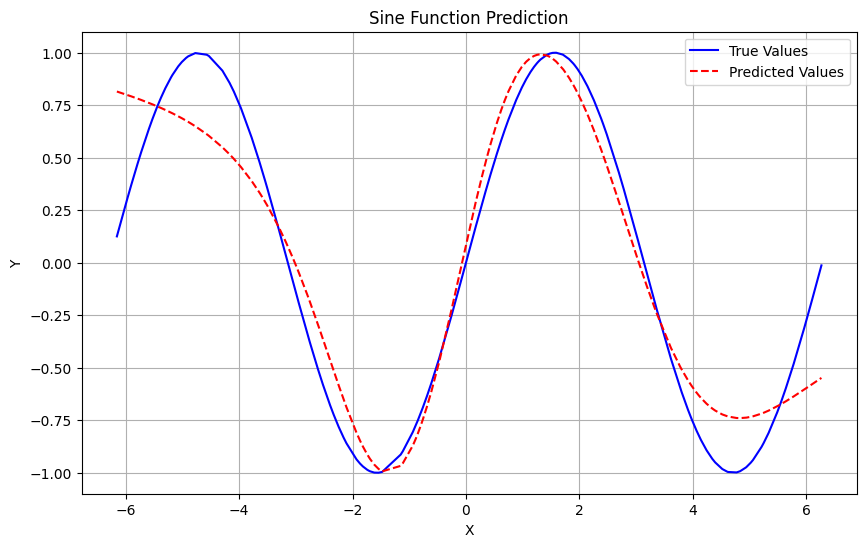

In [141]:
# Plotting function. Visualize your results
# this code assumes: print(X_test.shape, y_test.shape, y_pred.shape) --> (200, 1) (200, 1) (200,)

sorted_indices = np.argsort(X_test[:, 0]) # sorting is neeed because we randomized the data before
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = np.array([y.data for y in y_pred])[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted, y_test_sorted, label='True Values', color='blue')
plt.plot(X_test_sorted, y_pred_sorted, label='Predicted Values', color='red', linestyle='--')
plt.title('Sine Function Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

<mark>TODO</mark> Answer the following questions. Plot necessary graphs if needed.

* Which loss function gives the better validation loss? Keep the number of epoch and learning rate same.
* For the best loss function you find, which non-linearity performs the best?
* Does your best working solution overfit? How to prevent overfitting? Does regularization above prevent overfitting?
* How would you implement regularization without regularizing bias terms? Describe briefly in a paragraph. Be specific on what you will modify.

### Answers

1. The experiment with L2 loss function showed better result.
2. The trial with SiLU function obtained the best result, with L2 accuracy of 0.04327366.
3. The solution overfits the area from around -4 to 4, causing the remaining area to be underfitted. My hypothesis is: Since we do not give any weight, the model figured out that concentrating on center area is more efficient. Maybe we can give additional weight to the terminal areas to enforce training module to fit terminal areas as well.
4. One way to achieve it would be replacing raw `Value`s with a tuple of a `Value` and a boolean which is true iff the value is not a bias. That way we can distinguish between biases and weights.